<a href="https://colab.research.google.com/github/Cflalex/Practicum_StarUp/blob/main/StartUp_OK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow_decision_forests

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 909.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 61.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 90.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 89.9 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
  Attempting uninstall: tf-keras
    Found existing installation: tf_keras 2.17.0
    Uninstalling tf_keras-2.17.0:
 

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_decision_forests as tfdf
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
# Загружаем данные
data = pd.read_csv('/content/kaggle_startups_train_28062024.csv', parse_dates=['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at'])

In [ ]:
# Создаем новые признаки
current_date = pd.to_datetime('2018-01-01')
data['lifetime'] = (data['closed_at'].fillna(current_date) - data['founded_at']).dt.days
data['days_since_first_funding'] = (current_date - data['first_funding_at']).dt.days

# Проверим и заполним пропуски в данных
data['funding_total_usd'] = data['funding_total_usd'].fillna(0)  # Пропуски в числовых данных
data['category_list'] = data['category_list'].fillna('Unknown')  # Пропуски в категориальных данных
data['country_code'] = data['country_code'].fillna('Unknown')
data['state_code'] = data['state_code'].fillna('Unknown')
data['region'] = data['region'].fillna('Unknown')
data['city'] = data['city'].fillna('Unknown')




# Заменяем разделитель '|' на запятую ',' для обработки категорий как токенов
data['category_list'] = data['category_list'].fillna('').str.replace('|', ',', regex=False)


# Убедимся, что все данные имеют подходящие типы
categorical_columns = ['category_list', 'country_code', 'state_code', 'region', 'city']
for col in categorical_columns:
    data[col] = data[col].astype(str)

# Преобразование целевого признака в числовой формат
data['status'] = data['status'].map({'operating': 1, 'closed': 0})

# Убираем ненужные признаки
data = data.drop(columns=[ 'name', 'founded_at', 'first_funding_at', 'last_funding_at', 'closed_at'])

In [ ]:
data

,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,lifetime,days_since_first_funding
0,"Online Reservations,Restaurants",828626.0,1,CHE,25,Zurich,Zürich,2,2998,2437
1,"Manufacturing,Medical,Medical Devices",42935019.0,1,USA,CA,SF Bay Area,Redwood City,4,4748,2799
2,Biotechnology,35456381.0,1,USA,CA,SF Bay Area,San Jose,3,4383,1960
3,Health Care,22250000.0,1,Unknown,Unknown,Unknown,Unknown,3,5114,2314
4,Manufacturing,0.0,1,USA,VA,VA - Other,Bristol,1,2791,2161
...,...,...,...,...,...,...,...,...,...,...
52511,Entertainment,0.0,1,CAN,ON,Toronto,Kitchener,1,2192,1402
52512,Hospitality,500000.0,1,IND,2,Hyderabad,Hyderabad,1,1590,1396
52513,"Email,Messaging,Productivity Software",50000.0,1,USA,CA,SF Bay Area,San Francisco,3,2741,3123
52514,Security,13000000.0,1,USA,CA,SF Bay Area,San Jose,6,7336,6972


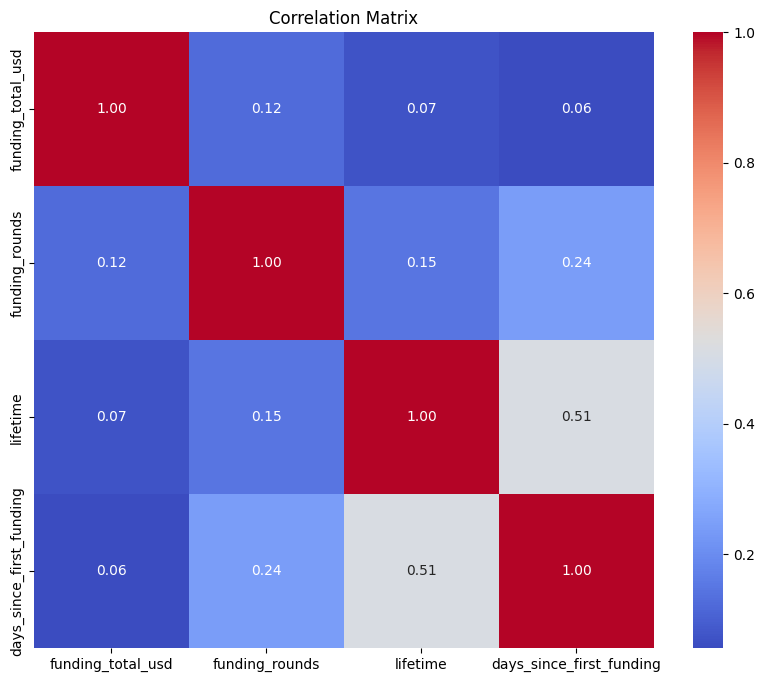


Variance Inflation Factor (VIF):
                    Feature       VIF
0         funding_total_usd  1.022667
1            funding_rounds  2.417122
2                  lifetime  3.953228
3  days_since_first_funding  4.747546


In [ ]:
# 1. Проверка корреляции между числовыми признаками
numeric_columns = ['funding_total_usd', 'funding_rounds', 'lifetime', 'days_since_first_funding']
correlation_matrix = data[numeric_columns].corr()

# Визуализация корреляционной матрицы
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# 2. Расчет VIF для числовых признаков
def calculate_vif(dataframe, features):
    vif_data = pd.DataFrame()
    vif_data['Feature'] = features
    vif_data['VIF'] = [variance_inflation_factor(dataframe[features].values, i) for i in range(len(features))]
    return vif_data

# Расчет VIF
vif = calculate_vif(data, numeric_columns)
print("\nVariance Inflation Factor (VIF):")
print(vif)

значения Variance Inflation Factor (VIF) показывают, что мультиколлинеарности в данных нет, так как:

Все значения VIF < 5, что является хорошим признаком. Обычно значения VIF > 10 сигнализируют о проблемах с мультиколлинеарностью, но у нас их нет.

In [ ]:
data['log_funding_total_usd'] = np.log1p(data['funding_total_usd'])
# Удаляем оригинальный столбец, чтобы избежать путаницы
data = data.drop(columns=['funding_total_usd'])


In [ ]:
# Отделяем классы
class_0 = data[data['status'] == 0]  # Класс с меткой 0
class_1 = data[data['status'] == 1]  # Класс с меткой 1

# Выполним недоусечение класса 1, чтобы он соответствовал размеру класса 0
class_1_downsampled = resample(class_1,
                               replace=False,  # Без замены
                               n_samples= len(class_0),  # Количество примеров равно числу класса 0
                               random_state=42)  # Фиксируем результат

# Объединяем классы обратно
balanced_data = pd.concat([class_0, class_1_downsampled])

# Перемешиваем данные
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Проверяем новое распределение классов
print(balanced_data['status'].value_counts())


status
1    4917
0    4917
Name: count, dtype: int64


In [ ]:
# Разделение на признаки и целевой признак
X = balanced_data.drop(columns=['status'])  # Признаки
y = balanced_data['status']  # Целевой признак

# Разделение данных на обучающую и тестовую выборки с учетом стратификации
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,  # 20% данных на тест
    random_state=42,  # Фиксируем результат
    stratify=y  # Учитываем стратификацию
)

# Проверка распределения классов
print("Распределение классов в обучающей выборке:")
print(y_train.value_counts())

print("\nРаспределение классов в тестовой выборке:")
print(y_test.value_counts())

Распределение классов в обучающей выборке:
status
1    3934
0    3933
Name: count, dtype: int64

Распределение классов в тестовой выборке:
status
0    984
1    983
Name: count, dtype: int64


In [ ]:
# Объединяем данные обратно для работы с TensorFlow Decision Forests
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

# Преобразование pandas DataFrame в формат TensorFlow Dataset
def df_to_tf_dataset(dataframe, label_column):
    labels = dataframe[label_column]
    features = dataframe.drop(columns=[label_column])
    return tf.data.Dataset.from_tensor_slices((dict(features), labels))

# Преобразуем данные в формат TensorFlow Dataset
train_ds = df_to_tf_dataset(train_data, label_column='status').batch(100)
test_ds = df_to_tf_dataset(test_data, label_column='status').batch(100)

In [40]:

# Создаем и обучаем модель
model = tfdf.keras.GradientBoostedTreesModel(
    task=tfdf.keras.Task.CLASSIFICATION,  # Классификация
    num_trees=500,  # Количество деревьев (можно варьировать)
    growing_strategy="BEST_FIRST_GLOBAL"  # Стратегия роста дерева
)
model.fit(train_ds)

Use /tmp/tmpejuzrjnv as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.768890. Found 7867 examples.
Training model...
Model trained in 0:00:01.419208
Compiling model...
Model compiled.


62/62 [==============================] - 0s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       984
           1       0.00      0.00      0.00       983

    accuracy                           0.50      1967
   macro avg       0.25      0.50      0.33      1967
weighted avg       0.25      0.50      0.33      1967



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


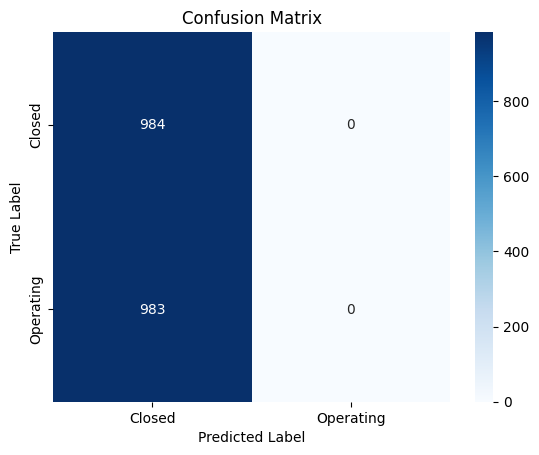

In [ ]:
# Предсказания на тестовых данных
test_features = {col: tf.convert_to_tensor(test_data[col].values) for col in X_test.columns}
predicted_log_values = model.predict(test_features)

# Разлогарифмирование предсказаний
y_pred = np.expm1(predicted_log_values)
y_pred_classes = np.argmax(y_pred, axis=1)  # Преобразуем вероятности в классы

# Метрики качества
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Closed', 'Operating'], yticklabels=['Closed', 'Operating'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Classification Report with Custom Threshold:
              precision    recall  f1-score   support

           0       1.00      0.81      0.89       984
           1       0.84      1.00      0.91       983

    accuracy                           0.90      1967
   macro avg       0.92      0.90      0.90      1967
weighted avg       0.92      0.90      0.90      1967



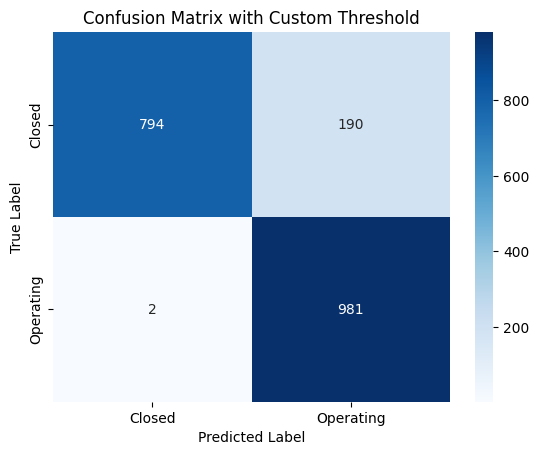

In [ ]:
# Устанавливаем порог для классификации
threshold = 0.18 # Настраиваем порог для вероятности принадлежности к классу 1
y_pred_custom = (y_pred >= threshold).astype(int)

# Пересчитываем метрики
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Пересчитанные метрики
print("Classification Report with Custom Threshold:")
print(classification_report(y_test, y_pred_custom))

# Пересчитанная матрица ошибок
cm = confusion_matrix(y_test, y_pred_custom)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Closed', 'Operating'], yticklabels=['Closed', 'Operating'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix with Custom Threshold')
plt.show()


In [ ]:
# Просмотр дерева и важности признаков
model.summary()

Model: "gradient_boosted_trees_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (9):
	category_list
	city
	country_code
	days_since_first_funding
	funding_rounds
	lifetime
	log_funding_total_usd
	region
	state_code

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1.                 "lifetime"  0.817273 ################
    2. "days_since_first_funding"  0.322565 ####
    3.                     "city"  0.234756 #
    4.            "category_list"  0.195628 
    5.                   "region"  0.187803 
    6.    "log_funding_total_usd"  0.171573 
    7.               "state_code"  0.169343 
    8.             "country_code"  0.160530 
    9.     

In [ ]:
# Шаг 1: Загрузка данных
test_data = pd.read_csv('/content/kaggle_startups_test_28062024.csv',
                        parse_dates=['first_funding_at'])

In [ ]:
# Шаг 2: Заполнение пропусков
test_data['funding_total_usd'] = test_data['funding_total_usd'].fillna(0)  # Пропуски в числовых данных
test_data['category_list'] = test_data['category_list'].fillna('Unknown')  # Пропуски в категориальных данных
test_data['country_code'] = test_data['country_code'].fillna('Unknown')
test_data['state_code'] = test_data['state_code'].fillna('Unknown')
test_data['region'] = test_data['region'].fillna('Unknown')
test_data['city'] = test_data['city'].fillna('Unknown')

test_data['log_funding_total_usd'] = np.log1p(test_data['funding_total_usd'])
test_data = test_data.drop(columns=['funding_total_usd'])


# Заменяем разделитель '|' на запятую ',' для обработки категорий как токенов
test_data['category_list'] = test_data['category_list'].fillna('').str.replace('|', ',', regex=False)



# Приведение категориальных данных к строковому формату
categorical_columns = ['category_list', 'country_code', 'state_code', 'region', 'city']
for col in categorical_columns:
    test_data[col] = test_data[col].astype(str)

# Шаг 3: Преобразование признаков
current_date = pd.to_datetime('2018-01-01')
test_data['days_since_first_funding'] = (current_date - test_data['first_funding_at']).dt.days

# Удаляем ненужные столбцы
test_data_features = test_data.drop(columns=['name', 'first_funding_at'])

# Шаг 4: Подготовка данных для модели
test_features = {col: tf.convert_to_tensor(test_data_features[col].values) for col in test_data_features.columns}

# Шаг 5: Предсказания
predicted_log_values = model.predict(test_features)

# Разлогарифмирование предсказаний
test_pred_prob = np.expm1(predicted_log_values)


# Устанавливаем порог для классификации
threshold = 0.18
test_pred = (test_pred_prob >= threshold).astype(int)

# Шаг 6: Замена меток на текстовые значения
status_map = {0: 'closed', 1: 'operating'}
test_pred_labels = [status_map[pred] for pred in test_pred.flatten()]

# Шаг 7: Создание файла для сабмита
submit = pd.DataFrame({
    'name': test_data['name'],  # Название компании
    'status': test_pred_labels  # Предсказанный статус
})

# Сохраняем файл для сабмита
submit.to_csv('/content/submission.csv', index=False)

print("Файл для сабмита сохранен как 'submission.csv'.")

411/411 [==============================] - 1s 2ms/step
Файл для сабмита сохранен как 'submission.csv'.


In [ ]:
submit

,name,status
0,Crystalsol,operating
1,JBI Fish & Wings,operating
2,COINPLUS,operating
3,Imagine Communications,closed
4,DNA13,operating
...,...,...
13120,Jymob,operating
13121,GlobaTrek,operating
13122,Inkd.com,operating
13123,AdWill,operating
